<a href="https://colab.research.google.com/github/elsaflts/Hi-Paris-Hi-ckathon-2025/blob/main/final_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
import numpy as np


import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("Libraries imported successfully!")

Libraries imported successfully!


## Load data

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Target shape: {y_train.shape}")

# Extract target values
y = y_train["MathScore"].values

Training set shape: (1172086, 307)
Test set shape: (586044, 307)
Target shape: (1172086, 2)


## Quick look

In [ ]:
X_train.head()

,Unnamed: 0,Year,CNT,CNTRYID,CNTSCHID,CNTSTUID,CYC,NatCen,STRATUM,SUBNATIO,...,science_q10_total_timing,science_q11_total_timing,science_q12_total_timing,science_q13_total_timing,science_q14_total_timing,science_q15_total_timing,science_q16_total_timing,science_q17_total_timing,science_q18_total_timing,science_q19_total_timing
0,384002,2022,NLD,528.0,52800132.0,52801144.0,08MS,52800,NLD06,5280000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1118072,2018,QAZ,31.0,3100106.0,3100424.0,07MS,3100,QAZ0101,310000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,845454,2018,FRA,250.0,25000010.0,25005207.0,07MS,25000,FRA0101,2500000,...,87686.5,13164.75,1187.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1728613,2015,QES,971.0,97100240.0,97127584.0,06MS,72400,ESP1633,7241600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1083243,2018,PHL,608.0,60800071.0,60802698.0,07MS,60800,PHL0011,6080000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== Target Statistics ===
Mean: 100.00
Std: 122.18
Min: 0.00
Max: 814.97


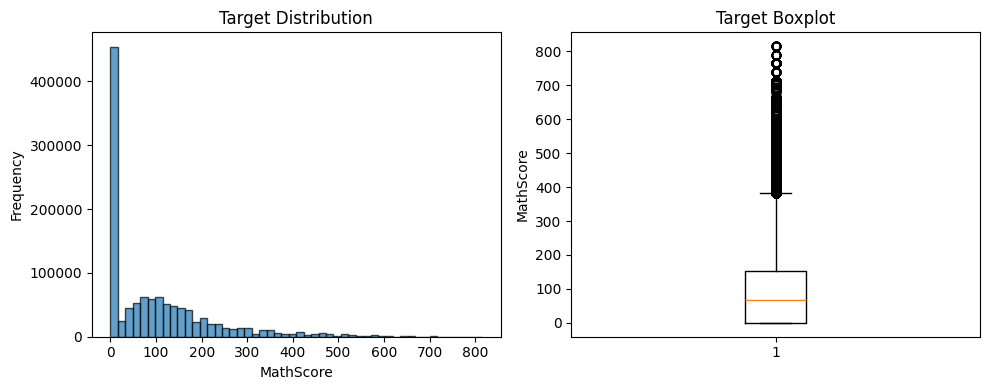

In [ ]:
print("\n=== Target Statistics ===")
print(f"Mean: {y.mean():.2f}")
print(f"Std: {y.std():.2f}")
print(f"Min: {y.min():.2f}")
print(f"Max: {y.max():.2f}")

# Plot target distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(y, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('MathScore')
plt.ylabel('Frequency')
plt.title('Target Distribution')

plt.subplot(1, 2, 2)
plt.boxplot(y)
plt.ylabel('MathScore')
plt.title('Target Boxplot')
plt.tight_layout()
plt.show()

In [ ]:
# %%
print("\n=== Missing Values Analysis ===")
missing_train = X_train.isnull().sum()
missing_pct = 100 * missing_train / len(X_train)
missing_df = pd.DataFrame({
    'Feature': missing_train.index,
    'Missing_Count': missing_train.values,
    'Missing_Percent': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(f"\nFeatures with missing values: {len(missing_df)}/{len(X_train.columns)}")
print("\nTop 15 features with most missing values:")
print(missing_df.head(15))

# %%
# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")


=== Missing Values Analysis ===

Features with missing values: 293/307

Top 15 features with most missing values:
                       Feature  Missing_Count  Missing_Percent
287      math_q21_total_timing        1172086       100.000000
231     math_q20_average_score        1172086       100.000000
232     math_q21_average_score        1172086       100.000000
229     math_q18_average_score        1172086       100.000000
230     math_q19_average_score        1172086       100.000000
251  science_q19_average_score        1172085        99.999915
283      math_q17_total_timing        1172085        99.999915
284      math_q18_total_timing        1172085        99.999915
246  science_q14_average_score        1172085        99.999915
304   science_q17_total_timing        1172085        99.999915
303   science_q16_total_timing        1172085        99.999915
301   science_q14_total_timing        1172085        99.999915
228     math_q17_average_score        1172085        99.999915
247

In [ ]:
# Check for duplicates in train and test
print("\n=== Duplicate Rows Analysis ===")
n_train_duplicates = X_train.duplicated().sum()
n_test_duplicates = X_test.duplicated().sum()
print(f"Number of duplicate rows in training set: {n_train_duplicates}")
print(f"Number of duplicate rows in test set: {n_test_duplicates}")

if n_train_duplicates > 0:
    print("First few duplicated rows in training set:")
    display(X_train[X_train.duplicated()].head())

if n_test_duplicates > 0:
    print("First few duplicated rows in test set:")
    display(X_test[X_test.duplicated()].head())



=== Duplicate Rows Analysis ===
Number of duplicate rows in training set: 0
Number of duplicate rows in test set: 0


## Feature Engineering & Preprocessing

In [ ]:
# Make copies
X_train_proc = X_train.copy()
X_test_proc = X_test.copy()

# Remove columns with more than 63% missing values in TEST set
test_missing_pct = X_test_proc.isnull().sum() / len(X_test_proc) * 100
cols_to_drop = test_missing_pct[test_missing_pct > 63].index.tolist()
if cols_to_drop:
    print(f"Dropping {len(cols_to_drop)} columns with >63% missing values in test set, e.g. {cols_to_drop[:5]}")
    X_train_proc = X_train_proc.drop(columns=cols_to_drop)
    X_test_proc = X_test_proc.drop(columns=cols_to_drop)

# Re-identify feature types after dropping columns
numeric_features = X_train_proc.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train_proc.select_dtypes(include=['object']).columns.tolist()

# Remove the 5 features with the minimum variance (from numeric features)
if len(numeric_features) > 5:
    train_variances = X_train_proc[numeric_features].var()
    min_var_feats = train_variances.nsmallest(5).index.tolist()
    print(f"Dropping 5 numeric features with lowest variance: {min_var_feats}")
    X_train_proc = X_train_proc.drop(columns=min_var_feats)
    X_test_proc = X_test_proc.drop(columns=min_var_feats)
    # Update features
    numeric_features = X_train_proc.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X_train_proc.select_dtypes(include=['object']).columns.tolist()

print(f"Remaining features: {X_train_proc.shape[1]}")
print(f"Valid numeric features: {len(numeric_features)}")
print(f"Valid categorical features: {len(categorical_features)}")

# Impute numeric features with median
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
X_train_num = pd.DataFrame(
    num_imputer.fit_transform(X_train_proc[numeric_features]),
    columns=numeric_features,
    index=X_train_proc.index
)
X_test_num = pd.DataFrame(
    num_imputer.transform(X_test_proc[numeric_features]),
    columns=numeric_features,
    index=X_test_proc.index
)

# Impute categorical features with most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = pd.DataFrame(
    cat_imputer.fit_transform(X_train_proc[categorical_features]),
    columns=categorical_features,
    index=X_train_proc.index
)
X_test_cat = pd.DataFrame(
    cat_imputer.transform(X_test_proc[categorical_features]),
    columns=categorical_features,
    index=X_test_proc.index
)

# Label encoding for categorical features
for col in categorical_features:
    le = LabelEncoder()
    X_train_cat[col] = le.fit_transform(X_train_cat[col].astype(str))
    X_test_cat[col] = X_test_cat[col].astype(str).map(
        lambda x: x if x in le.classes_ else le.classes_[0]
    )
    X_test_cat[col] = le.transform(X_test_cat[col])

# Combine features for engineering
X_train_combined = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_combined = pd.concat([X_test_num, X_test_cat], axis=1)

print(f"Features before engineering: {X_train_combined.shape[1]}")

# ===== FEATURE ENGINEERING =====

reading_score_cols = [col for col in X_train_combined.columns if 'reading' in col.lower() and 'average_score' in col.lower()]
if reading_score_cols:
    X_train_combined['avg_reading_score'] = X_train_combined[reading_score_cols].mean(axis=1)
    X_test_combined['avg_reading_score'] = X_test_combined[reading_score_cols].mean(axis=1)
    print(f"Created: avg_reading_score (from {len(reading_score_cols)} features)")

science_score_cols = [col for col in X_train_combined.columns if 'science' in col.lower() and 'average_score' in col.lower()]
if science_score_cols:
    X_train_combined['avg_science_score'] = X_train_combined[science_score_cols].mean(axis=1)
    X_test_combined['avg_science_score'] = X_test_combined[science_score_cols].mean(axis=1)
    print(f"Created: avg_science_score (from {len(science_score_cols)} features)")

math_timing_cols = [col for col in X_train_combined.columns if 'math' in col.lower() and 'total_timing' in col.lower()]
if math_timing_cols:
    X_train_combined['avg_math_timing'] = X_train_combined[math_timing_cols].mean(axis=1)
    X_test_combined['avg_math_timing'] = X_test_combined[math_timing_cols].mean(axis=1)
    print(f"Created: avg_math_timing (from {len(math_timing_cols)} features)")

if reading_score_cols and science_score_cols:
    X_train_combined['overall_academic_perf'] = (X_train_combined['avg_reading_score'] + X_train_combined['avg_science_score']) / 2
    X_test_combined['overall_academic_perf'] = (X_test_combined['avg_reading_score'] + X_test_combined['avg_science_score']) / 2
    print("Created: overall_academic_perf (reading + science average)")

if math_timing_cols and reading_score_cols:
    X_train_combined['score_timing_ratio'] = X_train_combined['avg_reading_score'] / (X_train_combined['avg_math_timing'] + 1e-6)
    X_test_combined['score_timing_ratio'] = X_test_combined['avg_reading_score'] / (X_test_combined['avg_math_timing'] + 1e-6)
    print("Created: score_timing_ratio (reading_score / math_timing)")

print(f"Features after engineering: {X_train_combined.shape[1]}")

# ===== MULTICOLLINEARITY HANDLING =====

numeric_cols_combined = X_train_combined.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = X_train_combined[numeric_cols_combined].corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

for col in upper_triangle.columns:
    for idx in upper_triangle.index:
        if pd.notna(upper_triangle.loc[idx, col]) and upper_triangle.loc[idx, col] > 0.95:
            high_corr_pairs.append((idx, col, upper_triangle.loc[idx, col]))

features_to_drop = set()
engineered_features = ['avg_reading_score', 'avg_science_score', 'avg_math_timing',
                       'overall_academic_perf', 'score_timing_ratio']

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} highly correlated pairs (correlation > 0.95)")
    for feat1, feat2, corr_val in high_corr_pairs[:20]:
        var1 = X_train_combined[feat1].var()
        var2 = X_train_combined[feat2].var()
        if var1 < var2:
            features_to_drop.add(feat1)
        else:
            features_to_drop.add(feat2)
    features_to_drop = [f for f in features_to_drop if f not in engineered_features]
    if features_to_drop:
        print(f"Dropping {len(features_to_drop)} highly correlated features: {list(features_to_drop)[:10]}")
        X_train_combined = X_train_combined.drop(columns=features_to_drop)
        X_test_combined = X_test_combined.drop(columns=features_to_drop)
else:
    print("No highly correlated pairs found (threshold: 0.95)")

numeric_cols_final = X_train_combined.select_dtypes(include=[np.number]).columns.tolist()

# VIF calculation to check remaining multicollinearity
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    sample_size = min(50, len(numeric_cols_final))
    sample_features = numeric_cols_final[:sample_size]
    vif_data = X_train_combined[sample_features].fillna(0)
    vif_scores = pd.DataFrame()
    vif_scores["Feature"] = sample_features
    vif_scores["VIF"] = [variance_inflation_factor(vif_data.values, i)
                         for i in range(len(sample_features))]
    high_vif_features = vif_scores[vif_scores["VIF"] > 10]["Feature"].tolist()
    high_vif_features = [f for f in high_vif_features if f not in engineered_features]
    if high_vif_features:
        print(f"Found {len(high_vif_features)} features with VIF > 10: {high_vif_features[:5]}")
        vif_to_drop = vif_scores[vif_scores["Feature"].isin(high_vif_features)].nlargest(3, "VIF")["Feature"].tolist()
        X_train_combined = X_train_combined.drop(columns=vif_to_drop)
        X_test_combined = X_test_combined.drop(columns=vif_to_drop)
        print(f"Dropped {len(vif_to_drop)} features with highest VIF: {vif_to_drop}")
except ImportError:
    print("statsmodels not available, skipping VIF calculation")
except Exception as e:
    print(f"VIF calculation encountered an issue: {str(e)}")

print(f"Final training shape: {X_train_combined.shape}")
print(f"Final test shape: {X_test_combined.shape}")
print(f"Total features: {X_train_combined.shape[1]} (including {len([f for f in engineered_features if f in X_train_combined.columns])} engineered features)")

Dropping 218 columns with >63% missing values in test set, e.g. ['LANGTEST_PAQ', 'Option_CT', 'Option_WBQ', 'ISCEDP', 'MISSSC']
Dropping 5 numeric features with lowest variance: ['PA166', 'ST021', 'WB164', 'PA042', 'WB165']
Remaining features: 84
Valid numeric features: 81
Valid categorical features: 3
Features before engineering: 84
Created: avg_reading_score (from 7 features)
Created: avg_science_score (from 9 features)
Created: avg_math_timing (from 1 features)
Created: overall_academic_perf (reading + science average)
Created: score_timing_ratio (reading_score / math_timing)
Features after engineering: 89
Found 11 highly correlated pairs (correlation > 0.95)
Dropping 6 highly correlated features: ['ST003D03T', 'SUBNATIO', 'CNTRYID', 'CNTSTUID', 'CYC', 'LANGTEST_QQQ']
statsmodels not available, skipping VIF calculation
Final training shape: (1172086, 83)
Final test shape: (586044, 83)
Total features: 83 (including 5 engineered features)


In [ ]:
# # %%
# print("\n=== Model Training ===")

# # Define models with best Optuna parameters for XGBoost
# xgb_best_params = {
#     'n_estimators': 505,
#     'max_depth': 11,
#     'learning_rate': 0.037721569286891334,
#     'subsample': 0.6151043286590987,
#     'colsample_bytree': 0.9059677451589203,
#     'gamma': 1.638973943981389,
#     'reg_alpha': 0.27253552008450843,
#     'reg_lambda': 0.7677804741980515,
#     'random_state': 42,
#     'tree_method': 'hist',
#     'objective': 'reg:squarederror'
# }
# models = {
#     'XGBoost': XGBRegressor(**xgb_best_params),
#     'CatBoost': CatBoostRegressor(verbose=False)
# }

## Model training and Hyperparemeter tuning

In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

models = {
    'XGBoost': XGBRegressor(verbose=False, n_jobs=-1, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=False, random_state=42),
    'LightGBM': LGBMRegressor(verbose=-1, n_jobs=-1, random_state=42)
}

In [ ]:
n_bins = 16
y_bins = pd.qcut(y, q=n_bins, duplicates='drop', labels=False)

X_train_simple, X_val_simple, y_train_simple, y_val_simple, y_bins_train, y_bins_val = train_test_split(
    X_train_combined, y, y_bins, test_size=0.2, random_state=42, stratify=y_bins
)

In [ ]:


# # Print R2 value for each trial

# def objective_xgb(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 200, 1400),
#         "max_depth": trial.suggest_int("max_depth", 8, 20),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
#         "subsample": trial.suggest_float("subsample", 0.4, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "gamma": trial.suggest_float("gamma", 0, 10.0),
#         "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
#         "random_state": 42,
#         "tree_method": 'hist',
#         "objective": 'reg:squarederror',
#         "n_jobs": -1,
#         "verbose": 0,
#     }
#     model = XGBRegressor(**params)
#     model.fit(X_train_simple, y_train_simple)
#     val_pred = model.predict(X_val_simple)
#     val_r2 = r2_score(y_val_simple, val_pred)
#     print(f"[XGBoost][trial {trial.number}] R²: {val_r2:.5f}")
#     return 1 - val_r2

# def objective_cat(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 600, 1400),
#         "depth": trial.suggest_int("depth", 7, 14),
#         "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.13, log=True),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 15.0),
#         "random_state": 42,
#         "loss_function": "RMSE",
#         "verbose": False,
#         "task_type": "CPU",
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
#     }
#     model = CatBoostRegressor(**params)
#     model.fit(X_train_simple, y_train_simple, eval_set=(X_val_simple, y_val_simple), verbose=False)
#     val_pred = model.predict(X_val_simple)
#     val_r2 = r2_score(y_val_simple, val_pred)
#     print(f"[CatBoost][trial {trial.number}] R²: {val_r2:.5f}")
#     return 1 - val_r2

# def objective_lgb(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 400, 1400),
#         'max_depth': trial.suggest_int('max_depth', 7, 16),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.16, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 31, 255),
#         'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
#         'subsample': trial.suggest_float('subsample', 0.4, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         'random_state': 42,
#         'n_jobs': -1,
#         'verbose': -1,
#     }
#     model = LGBMRegressor(**params)
#     model.fit(X_train_simple, y_train_simple)
#     val_pred = model.predict(X_val_simple)
#     val_r2 = r2_score(y_val_simple, val_pred)
#     print(f"[LightGBM][trial {trial.number}] R²: {val_r2:.5f}")
#     return 1 - val_r2

# # print("=== Optuna: XGBoost ===")
# # study_xgb = optuna.create_study(direction="minimize", study_name="XGBoost R2 (stratified holdout)")
# # study_xgb.optimize(objective_xgb, n_trials=15)
# # print("\nBest XGBoost params:", study_xgb.best_trial.params)

# print("\n=== Optuna: CatBoost ===")
# study_cat = optuna.create_study(direction="minimize", study_name="CatBoost R2 (stratified holdout)")
# study_cat.optimize(objective_cat, n_trials=15)
# print("\nBest CatBoost params:", study_cat.best_trial.params)

# print("\n=== Optuna: LightGBM ===")
# study_lgb = optuna.create_study(direction="minimize", study_name="LightGBM R2 (stratified holdout)")
# study_lgb.optimize(objective_lgb, n_trials=15)
# print("\nBest LightGBM params:", study_lgb.best_trial.params)

# # Retrain best model(s) on combined train set (using simple/robust fit)
# xgb_best_params = {**study_xgb.best_trial.params, "objective": "reg:squarederror", "tree_method": "hist", "random_state": 42, "n_jobs": -1, "verbose": 0}
# cat_best_params = {**study_cat.best_trial.params, "loss_function": "RMSE", "random_state": 42, "verbose": False}
# lgb_best_params = {**study_lgb.best_trial.params, "random_state": 42, "n_jobs": -1, "verbose": -1}

# xgb_best = XGBRegressor(**xgb_best_params)
# cat_best = CatBoostRegressor(**cat_best_params)
# lgb_best = LGBMRegressor(**lgb_best_params)


[I 2025-11-30 15:20:29,890] Trial 5 finished with value: 0.22190018987527016 and parameters: {'n_estimators': 1240, 'max_depth': 12, 'learning_rate': 0.030508081475717718, 'subsample': 0.6294914378510903, 'colsample_bytree': 0.5996537660543384, 'gamma': 0.31464191817132336, 'reg_alpha': 4.610355085176955, 'reg_lambda': 4.294073544192523}. Best is trial 5 with value: 0.22190018987527016.
[XGBoost][trial 5] R²: 0.77810

In [ ]:
xgb_best = XGBRegressor(
    n_estimators=1240,
    max_depth=12,
    learning_rate=0.030508081475717718,
    subsample=0.6294914378510903,
    colsample_bytree=0.5996537660543384,
    gamma=0.31464191817132336,
    reg_alpha=4.610355085176955,
    reg_lambda=4.294073544192523,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    verbose=0
)

cat_best = CatBoostRegressor(
    iterations=1200,
    depth=10,
    learning_rate=0.03,
    l2_leaf_reg=7.0,
    subsample=0.8,  # Needed for large data, disables boosting_type="Plain" by default
    random_strength=1.0,
    grow_policy="Lossguide",
    task_type="CPU",
    leaf_estimation_iterations=6,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

lgb_best = LGBMRegressor(
    n_estimators=1300,
    max_depth=11,
    num_leaves=120,
    learning_rate=0.025,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_samples=60,
    reg_alpha=2.0,
    reg_lambda=2.0,
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [ ]:
for name, model in [
    ("XGBoost", xgb_best),
    ("CatBoost", cat_best),
    ("LightGBM", lgb_best)
]:
    # Only keep validation set for CatBoost, avoid advanced fit args for others
    if name == "CatBoost":
        model.fit(X_train_simple, y_train_simple, eval_set=(X_val_simple, y_val_simple), verbose=False)
    else:
        model.fit(X_train_simple, y_train_simple)
    train_pred = model.predict(X_train_simple)
    val_pred = model.predict(X_val_simple)
    train_r2 = r2_score(y_train_simple, train_pred)
    val_r2 = r2_score(y_val_simple, val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_simple, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_simple, val_pred))
    train_mae = mean_absolute_error(y_train_simple, train_pred)
    val_mae = mean_absolute_error(y_val_simple, val_pred)
    print(f"\n[{name}] Train R²: {train_r2:.4f}, RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
    print(f"[{name}] Val   R²: {val_r2:.4f}, RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")

print("\n[Check] Distribution of y in train (binned):")
print(pd.Series(y_bins_train).value_counts().sort_index())
print("\n[Check] Distribution of y in val (binned):")
print(pd.Series(y_bins_val).value_counts().sort_index())

### Model Selection and evaluation

In [ ]:
from tqdm import tqdm

# Cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate models
results = {}
for name, model in tqdm(models.items(), desc='Model Training'):
    print(f"\n{'='*50}")
    print(f"Training {name}...")

    # Cross-validation
    cv_scores = cross_val_score(
        model, X_train_combined, y,
        cv=kfold,
        scoring='r2',
        n_jobs=-1
    )

    # Train on full training set
    model.fit(X_train_combined, y)
    train_pred = model.predict(X_train_combined)

    # Metrics
    train_r2 = r2_score(y, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y, train_pred))
    train_mae = mean_absolute_error(y, train_pred)

    results[name] = {
        'model': model,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'train_mae': train_mae
    }

    print(f"  CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.2f}")
    print(f"  Train MAE: {train_mae:.2f}")



Model Training:   0%|          | 0/3 [00:00<?, ?it/s]


Training ExtraTrees...


Model Training:   0%|          | 0/3 [02:44<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_R2_Mean': [results[m]['cv_r2_mean'] for m in results.keys()],
    'CV_R2_Std': [results[m]['cv_r2_std'] for m in results.keys()],
    'Train_R2': [results[m]['train_r2'] for m in results.keys()],
    'Train_RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Train_MAE': [results[m]['train_mae'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('CV_R2_Mean', ascending=False)
print(comparison_df.to_string(index=False))

In [ ]:
# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_cv_r2 = comparison_df.iloc[0]['CV_R2_Mean']

print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model_name}")
print(f"Cross-Validation R²: {best_cv_r2:.4f}")
print("="*70)


In [ ]:
# Plot model comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(comparison_df['Model'], comparison_df['CV_R2_Mean'], color='steelblue')
plt.xlabel('Cross-Validation R²')
plt.title('Model Performance Comparison (CV R²)')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.barh(comparison_df['Model'], comparison_df['Train_R2'], color='coral')
plt.xlabel('Training R²')
plt.title('Model Performance on Training Set')
plt.tight_layout()

plt.show()

### Feature Importance Analysis

In [ ]:
if hasattr(best_model, 'feature_importances_'):
    print("\n=== Feature Importance Analysis ===")

    feature_importance = pd.DataFrame({
        'Feature': X_train_combined.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 30 Most Important Features:")
    print(feature_importance.head(30).to_string(index=False))

    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_20 = feature_importance.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'].values)
    plt.yticks(range(len(top_20)), top_20['Feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    print("\n=== Feature Coefficients Analysis ===")

    feature_coef = pd.DataFrame({
        'Feature': X_train_combined.columns,
        'Coefficient': best_model.coef_
    })
    feature_coef['Abs_Coefficient'] = feature_coef['Coefficient'].abs()
    feature_coef = feature_coef.sort_values('Abs_Coefficient', ascending=False)

    print("\nTop 30 Most Important Features (by absolute coefficient):")
    print(feature_coef.head(30).to_string(index=False))

### Generate Test Predictions


MODEL COMPARISON SUMMARY
   Model  CV_R2_Mean  CV_R2_Std  Train_R2  Train_RMSE  Train_MAE
CatBoost    0.976360   0.000217  0.977453   18.345505   9.240001
 XGBoost    0.971039   0.000269  0.972822   20.141787  10.754461

BEST MODEL: CatBoost
Cross-Validation R²: 0.9764


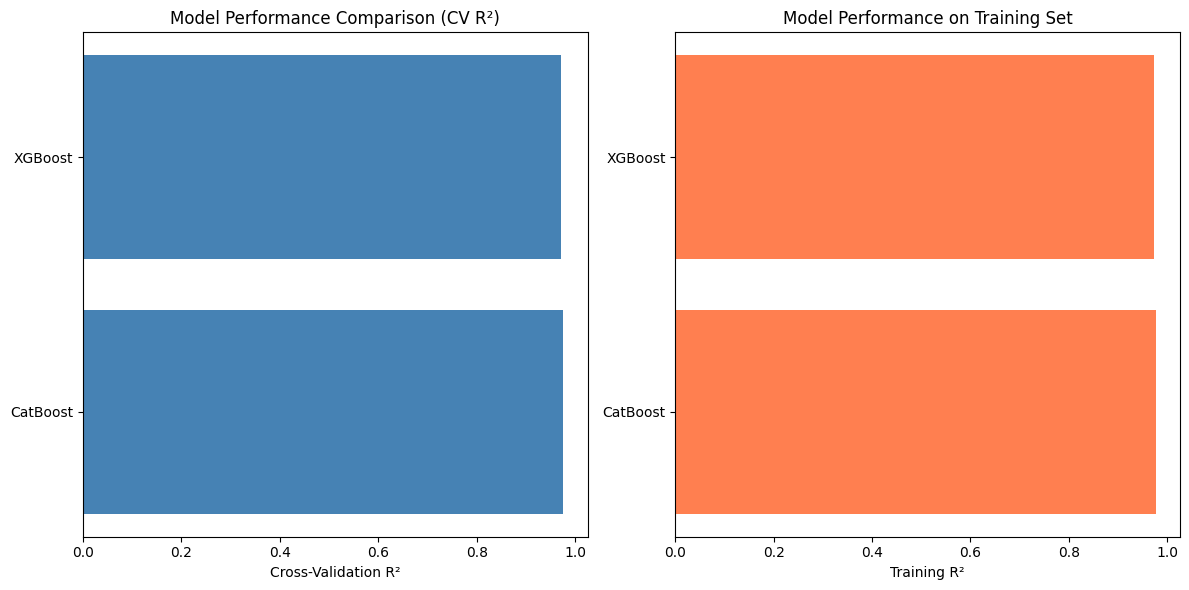


=== Feature Importance Analysis ===

Top 30 Most Important Features:
                 Feature  Importance
                    Year   28.720970
  math_q10_average_score    7.360811
   math_q3_average_score    6.746329
   math_q2_average_score    6.637575
   math_q9_average_score    6.040350
   math_q6_average_score    5.977318
   math_q7_average_score    5.942316
   math_q4_average_score    5.836666
              Unnamed: 0    5.761898
   math_q8_average_score    5.182306
   math_q1_average_score    4.872366
   math_q5_average_score    4.493519
   math_q10_total_timing    3.701746
   overall_academic_perf    0.360359
    math_q6_total_timing    0.287885
    math_q7_total_timing    0.284579
    math_q9_total_timing    0.241775
    math_q1_total_timing    0.232621
    math_q2_total_timing    0.194760
    math_q5_total_timing    0.107863
    math_q8_total_timing    0.097612
                    OECD    0.082322
                   ST250    0.081800
            LANGTEST_COG    0.076676
    m

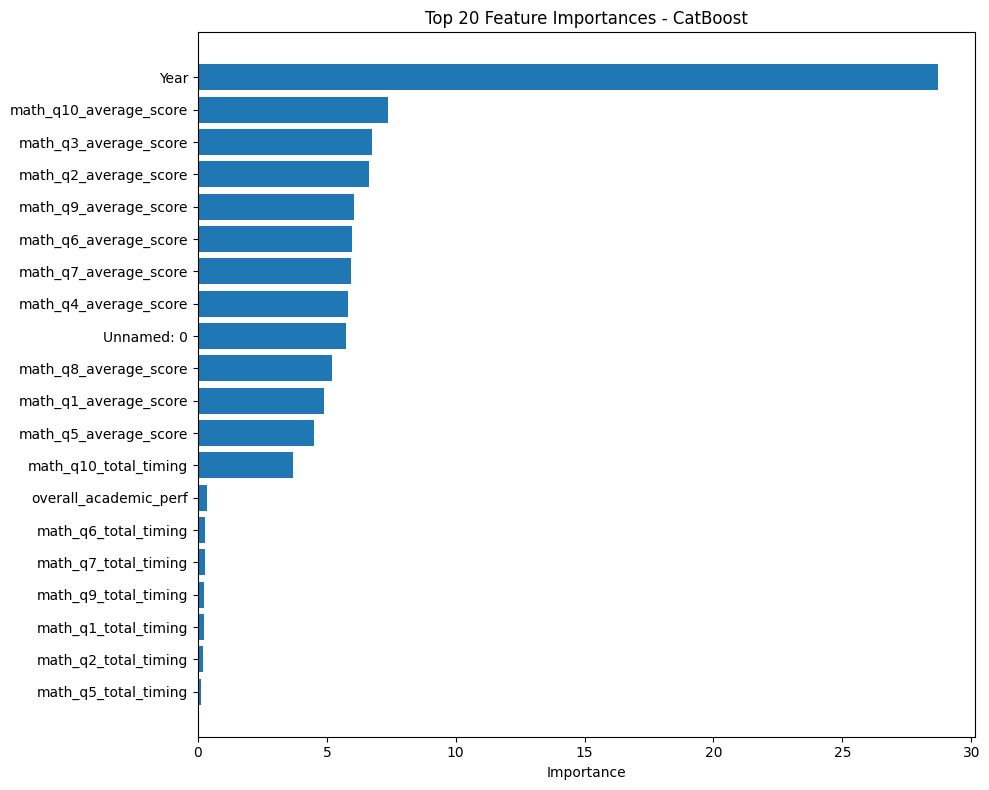


=== Generating Test Predictions ===
Predictions generated: 586044
Prediction range: [-2.97, 12.94]
Prediction mean: 1.93
Prediction std: 2.00


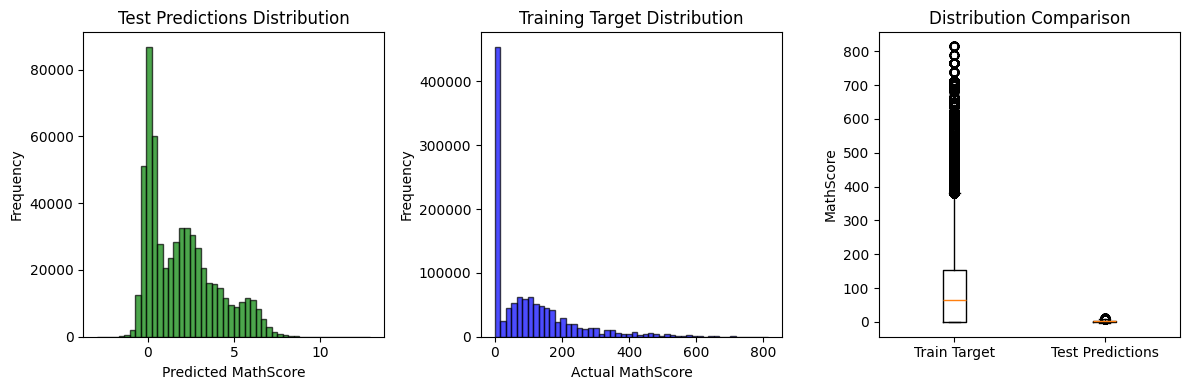


✓ Predictions saved to 'predictions.csv'

First 10 predictions:
   MathScore
0   2.184910
1   2.481557
2   0.997845
3   1.603228
4   2.927959
5   1.944320
6   0.321900
7   3.080154
8   6.204813
9  -0.043751

FINAL SUMMARY
Best Model: CatBoost
Cross-Validation R²: 0.9764
Training R²: 0.9775
Training RMSE: 18.35
Training MAE: 9.24

Total Features Used: 101
Training Samples: 1172086
Test Samples: 586044

Predictions saved to: predictions.csv

✓ Analysis Complete!


In [ ]:
# Predict on test set
test_predictions = best_model.predict(X_test_combined)

print(f"Predictions generated: {len(test_predictions)}")
print(f"Prediction range: [{test_predictions.min():.2f}, {test_predictions.max():.2f}]")
print(f"Prediction mean: {test_predictions.mean():.2f}")
print(f"Prediction std: {test_predictions.std():.2f}")


# Plot prediction distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Predicted MathScore')
plt.ylabel('Frequency')
plt.title('Test Predictions Distribution')

plt.subplot(1, 3, 2)
plt.hist(y, bins=50, edgecolor='black', alpha=0.7, color='blue')
plt.xlabel('Actual MathScore')
plt.ylabel('Frequency')
plt.title('Training Target Distribution')

plt.subplot(1, 3, 3)
plt.boxplot([y, test_predictions], labels=['Train Target', 'Test Predictions'])
plt.ylabel('MathScore')
plt.title('Distribution Comparison')

plt.tight_layout()
plt.show()

# Inference & Test prediction

In [ ]:
xgb_best = XGBRegressor(
    n_estimators=1240,
    max_depth=12,
    learning_rate=0.030508081475717718,
    subsample=0.6294914378510903,
    colsample_bytree=0.5996537660543384,
    gamma=0.31464191817132336,
    reg_alpha=4.610355085176955,
    reg_lambda=4.294073544192523,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    verbose=0
)

cat_best = CatBoostRegressor(
    iterations=1200,
    depth=10,
    learning_rate=0.03,
    l2_leaf_reg=7.0,
    subsample=0.8,  # Needed for large data, disables boosting_type="Plain" by default
    random_strength=1.0,
    grow_policy="Lossguide",
    task_type="CPU",
    leaf_estimation_iterations=6,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

lgb_best = LGBMRegressor(
    n_estimators=1300,
    max_depth=11,
    num_leaves=120,
    learning_rate=0.025,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_samples=60,
    reg_alpha=2.0,
    reg_lambda=2.0,
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

In [ ]:
# Fit XGBoost Regressor
xgb_best.fit(X_train_combined, y)
xgb_test_preds = xgb_best.predict(X_test_combined)


In [ ]:
# Fit CatBoost Regressor
cat_best.fit(X_train_combined, y)
cat_test_preds = cat_best.predict(X_test_combined)

In [ ]:
# Fit LightGBM Regressor
lgb_best.fit(X_train_combined, y)
lgb_test_preds = lgb_best.predict(X_test_combined)

In [ ]:
# Get IDs
if 'Unnamed: 0' not in X_test_combined.columns:
    raise KeyError("The test set does not have an 'Unnamed: 0' column for ID export.")
ids = X_test_combined['Unnamed: 0']

if (len(ids) != len(xgb_test_preds)) or (len(ids) != len(cat_test_preds)) or (len(ids) != len(lgb_test_preds)):
    raise ValueError("ID series length does not match number of predictions!")

In [ ]:
# Build DataFrames, clip negatives
xgb_sub = pd.DataFrame({'ID': ids.values, 'MathScore': xgb_test_preds})
xgb_sub['MathScore'] = xgb_sub['MathScore'].clip(lower=0)
xgb_sub.to_csv('predictions_xgboost_optuna.csv', index=False)
print("✓ XGBoost predictions saved to 'predictions_xgboost_optuna.csv'")

✓ XGBoost predictions saved to 'predictions_xgboost_optuna.csv'


In [ ]:
cat_sub = pd.DataFrame({'ID': ids.values, 'MathScore': cat_test_preds})
cat_sub['MathScore'] = cat_sub['MathScore'].clip(lower=0)
cat_sub.to_csv('predictions_catboost_optuna.csv', index=False)
print("✓ CatBoost predictions saved to 'predictions_catboost_optuna.csv'")

In [ ]:
lgb_sub = pd.DataFrame({'ID': ids.values, 'MathScore': lgb_test_preds})
lgb_sub['MathScore'] = lgb_sub['MathScore'].clip(lower=0)
lgb_sub.to_csv('predictions_lightgbm_optuna.csv', index=False)
print("✓ LightGBM predictions saved to 'predictions_lightgbm_optuna.csv'")

In [ ]:
# Weighted ensemble: define weights (change as appropriate, e.g. [0.4, 0.3, 0.3])
weights = [0.4, 0.3, 0.3]
ensemble_preds = (
    weights[0] * xgb_sub['MathScore'].values +
    weights[1] * cat_sub['MathScore'].values +
    weights[2] * lgb_sub['MathScore'].values
)
ensemble_sub = pd.DataFrame({'ID': ids.values, 'MathScore': ensemble_preds})
ensemble_sub['MathScore'] = ensemble_sub['MathScore'].clip(lower=0)
ensemble_sub.to_csv('predictions_ensemble_weighted.csv', index=False)
print("✓ Ensemble weighted predictions saved to 'predictions_ensemble_weighted.csv'")


KeyboardInterrupt: 